## GMM Estimation of Model Parameters of Expectation Formation

- This notebook includes functions that estimate the parameter of rigidity for different models
- It allows for flexible choices of moments to be used, forecast error, disagreement, and uncertainty, etc. 
- It includes 
  - A general function that implements the estimation using the minimum distance algorithm. 
  - Model-specific functions that take real-time data and process parameters as inputs and produces forecasts and moments as outputs. It is model-specific because different models of expectation formation bring about different forecasts. 
  - Auxiliary functions that compute the moments as well as the difference of data and model prediction, which will be used as inputs for GMM estimator. 

### 1. Estimation algorithms 

In [52]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [53]:
# a general-purpose estimating function of the parameter
def Estimator(obj_func,para_guess,method='CG'):
    """
    Inputs
    ------
    - moments: a function of the rigidity model parameter  
    - method: method of optimization 
    
    Outputs
    -------
    - parameter: an array of estimated parameter
    """
    
    parameter = minimize(obj_func,x0 = para_guess,method=method)['x']
    return parameter 

In [54]:
# a function that prepares moment conditions. So far the loss being simply the norm of the difference
def PrepMom(model_moments,data_moments):
    """
    Inputs
    -----
    model_moments: an array of moments from a certain model, i.e. forecast error, disagreement and uncertainty. 
    data_moments: an array of moments computed from the survey data
    
    Outputs
    ------
    diff: the Euclidean distance of two arrays of data and model 
    
    """
    diff = np.linalg.norm(model_moments - data_moments)
    return diff

In [55]:
## auxiliary functions 
def hstepvar(h,sigma,rho):
    return sum([ rho**(2*i)*sigma**2 for i in range(h)] )

np.random.seed(12345)
def hstepfe(h,sigma,rho):
    return sum([rho**i*(np.random.randn(1)*sigma)*np.random.randn(h)[i] for i in range(h)])
## This is not correct. 


def ForecastPlot(test):
    x = plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label=val)
        plt.legend(loc=1)
    return x
        
def ForecastPlotDiag(test,data):
    x = plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label='model:'+ val)
        plt.plot(np.array(data[val]),label='data:'+ val)
        plt.legend(loc=1)
    return x
        
### AR1 simulator 
def AR1_simulator(rho,sigma,nobs):
    xxx = np.zeros(nobs+1)
    shocks = np.random.randn(nobs+1)*sigma
    xxx[0] = 0 
    for i in range(nobs):
        xxx[i+1] = rho*xxx[i] + shocks[i+1]
    return xxx[1:]

In [56]:
## some process parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

In [57]:
### create fake real-time data 
xxx = AR1_simulator(rho,sigma,100)

In [58]:
## RE class 
class RationalExpectation:
    def __init__(self,real_time,horizon=1,process_para = process_para,exp_para = {},max_back =10):
        self.real_time = real_time
        self.horizon = horizon
        self.process_para = process_para
        self.max_back = max_back
    
    def GetRealization(self,realized_series):
        self.realized = realized_series
        
    def SimulateRealization(self):
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.realized = realized        
        
    def REForecaster(self):
        ## parameters
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        
        ## parameters
        max_back = self.max_back
        real_time = self.real_time
        horizon = self.horizon
        
        ## forecast moments 
        Disg =np.zeros(n)
        infoset = real_time
        nowcast = infoset
        forecast = rho**horizon*nowcast
        Var = hstepvar(horizon,sigma,rho)* np.ones(n)
        FE = forecast - self.realized ## forecast errors depend on realized shocks 
        return {"Forecast":forecast,
                "FE":FE,
               "Disg":Disg,
               "Var":Var}

In [59]:
### create a RE instance 
FE_instance = RationalExpectation(real_time = xxx)

In [60]:
### simulate a realized series 
FE_instance.SimulateRealization()

In [61]:
### forecster
fe_moms = FE_instance.REForecaster()
#ForecastPlot(fe_moms)

In [62]:
## expectation parameters 
SE_para_default = {'lambda':0.8}

In [65]:
## SE class 
class StickyExpectation:
    def __init__(self,real_time,horizon=1,
                 process_para = process_para,
                 exp_para = SE_para_default,
                 max_back =10):
        self.real_time = real_time
        self.n = len(real_time)
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.max_back = max_back
        self.data_moms_dct ={}
        self.para_est = {}
        self.moments = ['Forecast','Disg','Var']
        
    def GetRealization(self,realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = self.n
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] +cum_shock
        self.realized = realized
        
    def SEForecaster(self):
        ## inputs 
        real_time = self.real_time
        n = len(real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        lbd = self.exp_para['lambda']
        max_back = self.max_back
        horizon = self.horizon      
        
        ## forecast moments 
        #FE = sum( [lbd*(1-lbd)**tau*hstepfe(horizon+tau,sigma,rho) for tau in range(max_back)] ) * np.ones(n) # a function of lambda, real-time and process_para 
        Var = sum([ lbd*(1-lbd)**tau*hstepvar(horizon+tau,sigma,rho) for tau in range(max_back)] ) * np.ones(n)  
        # same as above 
        nowcast = sum([ lbd*(1-lbd)**tau*(rho**tau)*np.roll(real_time,tau) for tau in range(max_back)]) 
        # the first tau needs to be burned
        forecast = rho**horizon*nowcast
        FE = forecast - self.realized
        Disg =  sum([ lbd*(1-lbd)**tau*(rho**(tau+horizon)*np.roll(real_time,tau)-forecast)**2 for tau in range(max_back)] )
        return {"Forecast":forecast, 
                "FE":FE,
                "Disg":Disg,
                "Var":Var}
    
    ## a function estimating SE model parameter only 
    def SE_EstObjfunc(self,lbd):
        """
        input
        -----
        lbd: the parameter of SE model to be estimated
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        SE_para = {"lambda":lbd}
        self.exp_para = SE_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        
        SE_moms_dct = self.SEForecaster()
        SE_moms = np.array([SE_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(SE_moms,data_moms)
        return obj_func 
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,para_guess=0.2,method='CG'):
        self.para_est = Estimator(self.SE_EstObjfunc,para_guess=para_guess,method='CG')

In [66]:
### create a SE instance using fake real time data 
SE_instance = StickyExpectation(real_time = xxx)

In [67]:
### simulate a realized series 
SE_instance.SimulateRealization()

In [68]:
### fake data moments 
data_moms_dct_fake = SE_instance.SEForecaster()

In [69]:
#plot = ForecastPlot(data_moms_dct_fake)

In [70]:
### feed the data moments
SE_instance.GetDataMoments(data_moms_dct_fake)

In [71]:
### invokes the estimation 
SE_instance.ParaEstimate()
SE_instance.para_est

array([0.69678546])

In [72]:
NI_para_default = {'sigma_pb':0.2,
                  'sigma_pr':0.1}

In [86]:
## class of Noisy information 

class NoisyInformation:
    def __init__(self,real_time,
                 horizon=1,
                 process_para = process_para, 
                 exp_para = NI_para_default):
        self.real_time = real_time
        self.n = len(real_time)
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.data_moms_dct ={}
        self.para_est = {}
        self.moments = ['Forecast','Disg','Var']
        
    def GetRealization(self,realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = self.n
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.realized = realized
        
    def SimulateSignals(self):
        n = self.n
        sigma_pb = self.exp_para['sigma_pb']
        sigma_pr =self.exp_para['sigma_pr']
        s_pb = self.real_time+sigma_pb*np.random.randn(n)
        s_pr = self.real_time+sigma_pr*np.random.randn(n)
        self.signals = np.asmatrix(np.array([s_pb,s_pr]))
        
    # a function that generates population moments according to NI     
    def NIForecaster(self):
        ## inputs 
        real_time = self.real_time
        n = self.n
        rho  = self.process_para['rho']
        sigma = self.process_para['sigma']
        sigma_pb = self.exp_para['sigma_pb']
        sigma_pr =self.exp_para['sigma_pr']
        sigma_v = np.asmatrix([[sigma_pb**2,0],[0,sigma_pr**2]])
        horizon = self.horizon      
        s = self.signals
        nb_s=len(self.signals) ## # of signals 
        H = np.asmatrix ([[1,1]]).T
        Pkalman = np.zeros([n,nb_s])
        nowcast = np.zeros(n)
        nowcast[0] = real_time[0]
        nowvar = np.zeros(n)
        nowvar[0]= sigma**2/(1-rho**2)
        Var = np.zeros(n)
     
        ## forecast moments
        infoset = s
        
        for t in range(n-1):
            Pkalman[t+1] = nowcast[t]*H.T*np.linalg.inv(H*nowcast[t]*H.T+sigma_v)
            nowcast[t+1] = (1-Pkalman[t+1]*H)*rho*nowcast[t]+ Pkalman[t+1,0]*infoset[0,t+1]
            nowvar[t+1] = nowvar[t]-nowvar[t]*H.T*np.linalg.inv(H*nowvar[t]*H.T+sigma_v)*H*nowvar[t]
            
        forecast = rho**horizon*nowcast    
        FE = forecast - self.realized  

        for t in range(n):
            Var[t] = rho**(2*horizon)*nowvar[t] + hstepvar(horizon,sigma,rho)
              
        Disg = Pkalman[:,0]**2*rho**(2*horizon)*sigma_pr**2*np.ones(n)  #same as above

        return {"Forecast":forecast,
                "FE":FE,
                "Disg":Disg,
                "Var":Var}
    ## a function estimating SE model parameter only 
    def NI_EstObjfunc(self,sigmas,moments = ['Forecast','Disg']):
        """
        input
        -----
        sigma: the parameters of NI model to be estimated. A vector of sigma_pb and sigma_pr
        
        output
        -----
        the objective function to minmize
        """
        NI_para = {"sigma_pb":sigmas[0],
                  "sigma_pr":sigmas[1]}
        self.exp_para = NI_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        
        NI_moms_dct = self.NIForecaster()
        NI_moms = np.array([NI_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(NI_moms,data_moms)
        return obj_func 
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,para_guess=np.array([0.2,0.2]),method='CG'):
        self.para_est = Estimator(self.NI_EstObjfunc,para_guess=para_guess,method='CG')
    



In [87]:
ni_instance = NoisyInformation(real_time = xxx)

In [88]:
ni_instance.SimulateRealization()
ni_instance.SimulateSignals()
ni_mom_dct = ni_instance.NIForecaster()

In [89]:
#plt.plot(ni_instance.signals.T)
#plt.plot(xxx,'r-')

In [90]:
#plt.plot(ni_mom_dct['Forecast'],label='forecast')
#plt.plot(ni_instance.realized,label='realized')
#plt.legend(loc=1)

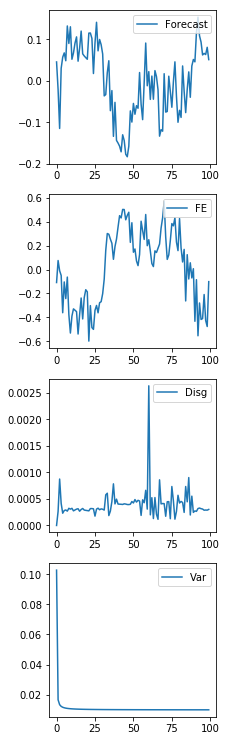

In [91]:
#ni_plot = ForecastPlot(ni_mom_dct)

In [92]:
fake_data_moms_dct = ni_mom_dct
ni_instance.GetDataMoments(fake_data_moms_dct)

In [93]:
'''
ni_instance.ParaEstimate(para_guess=np.array([0.01,0.01]))
params_est_NI = ni_instance.para_est
print(params_est_NI)
'''

'\nni_instance.ParaEstimate(para_guess=np.array([0.01,0.01]))\nparams_est_NI = ni_instance.para_est\nprint(params_est_NI)\n'

In [36]:
'''
## estimate for many times 
nb_sim = 100
sim_para = np.zeros([1,2])

for i in range(nb_sim):
    ni_instance.SimulateRealization()
    ni_instance.SimulateSignals()
    ni_instance.GetDataMoments(fake_data_moms_dct)
    ni_instance.ParaEstimate()
    sim_para += ni_instance.para_est
est_av = sim_para/nb_sim

print(est_av)
'''

'\n## estimate for many times \nnb_sim = 100\nsim_para = np.zeros([1,2])\n\nfor i in range(nb_sim):\n    ni_instance.SimulateRealization()\n    ni_instance.SimulateSignals()\n    ni_instance.GetDataMoments(fake_data_moms_dct)\n    ni_instance.ParaEstimate()\n    sim_para += ni_instance.para_est\nest_av = sim_para/nb_sim\n\nprint(est_av)\n'